In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

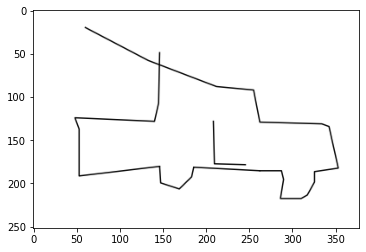

In [2]:
plt.imshow(Image.open('./data/car_train_data/car/102.jpg'));

In [3]:
!ls data/car_train_data/

car     not_car


# CNN

In [4]:
classifier = tf.keras.Sequential()

classifier.add(tf.keras.layers.Conv2D(32, (3 ,3), input_shape=(128, 128, 3), activation='relu'))
classifier.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

classifier.add(tf.keras.layers.Conv2D(20, (3, 3), activation='relu'))
classifier.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

classifier.add(tf.keras.layers.Conv2D(12, (3, 3), activation='relu'))
classifier.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

classifier.add(tf.keras.layers.Conv2D(8, (3, 3), activation='relu'))
classifier.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

classifier.add(tf.keras.layers.Flatten())

classifier.add(tf.keras.layers.Dense(activation='relu', units=128))
classifier.add(tf.keras.layers.Dense(activation='sigmoid', units=1))

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2021-12-13 14:15:37.134809: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 20)        5780      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 20)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 12)        2172      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 12)       0

In [6]:
image_size = (128,128)
batch_size_chosen = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                   zoom_range=0.2,
                                   rotation_range = 15,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory('data/car_train_data/',
                                                    target_size=image_size,
                                                    batch_size=batch_size_chosen,
                                                    class_mode='binary')

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
validation_generator = test_datagen.flow_from_directory('data/car_test_data/',
                                                        target_size=image_size,
                                                        batch_size=batch_size_chosen,
                                                        class_mode='binary')

Found 131 images belonging to 2 classes.
Found 131 images belonging to 2 classes.


In [7]:
!rm -r data/logs/

In [8]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                   min_delta=0,
                                   patience=3,
                                   verbose=1,
                                   mode='auto',
                                   restore_best_weights=True)

ts = tf.keras.callbacks.TensorBoard(log_dir='data/logs',
                                 histogram_freq=0,
                                 write_graph=True,
                                 write_grads=False,
                                 write_images=False,
                                 embeddings_freq=0,
                                 embeddings_layer_names=None,
                                 embeddings_metadata=None,
                                 embeddings_data=None,
                                 update_freq='epoch')

train_generator.class_indices

{'car': 0, 'not_car': 1}

In [9]:
classifier.fit_generator(train_generator,
                         steps_per_epoch=50,
                         epochs=3,
                         validation_data=validation_generator,
                         validation_steps=200,
                         workers=4,
                         callbacks=[es, ts])

/var/folders/0b/2vd83sj57l759q5x6tqmpsn40000gn/T/ipykernel_58331/801637673.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  classifier.fit_generator(train_generator,


Epoch 1/3
50/50 [==============================] - 23s 445ms/step - loss: 0.3316 - accuracy: 0.9084 - val_loss: 0.3214 - val_accuracy: 0.9084
Epoch 2/3
50/50 [==============================] - 23s 453ms/step - loss: 0.3183 - accuracy: 0.9084 - val_loss: 0.3239 - val_accuracy: 0.9084
Epoch 3/3
50/50 [==============================] - 22s 435ms/step - loss: 0.3155 - accuracy: 0.9084 - val_loss: 0.3106 - val_accuracy: 0.9084


In [10]:
classifier.save('model/model.h5')

In [11]:
model = tf.keras.models.load_model('model/model.h5')

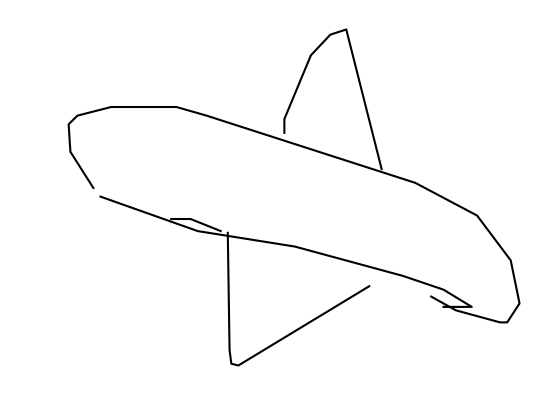

In [12]:
Image.open('data/car_test_data/not_car/airplane_77.jpg')

In [13]:
img = np.array(Image.open('data/car_test_data/not_car/airplane_77.jpg').convert('RGB').resize((128,128))).reshape(1,128,128,3)*1/255
model.predict(img)

array([[0.86216486]], dtype=float32)

In [14]:
img = np.array(Image.open('data/car_test_data/car/103.jpg').convert('RGB').resize((128,128))).reshape(1,128,128,3)*1/255
model.predict(img)

array([[0.8630873]], dtype=float32)

# Viz

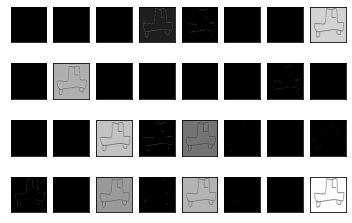

In [11]:
from tensorflow.keras import models

def plot_activation(activation, plot_height, plot_width):
    ix = 1
    for _ in range(plot_height):
        for _ in range(plot_width):
            # specify subplot and turn of axis
            ax = plt.subplot(plot_height, plot_width, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(activation[0, :, :, ix - 1], cmap='gray')
            ix += 1
    plt.show()

def plot_neuron(neuron, number, vmin=None, vmax=None):
    ix = 1
    vmin = min(neuron[0, :number]) if vmin is None else vmin
    vmax = max(neuron[0, :number]) if vmax is None else vmax
    for _ in range(number):
        # specify subplot and turn of axis
        ax = plt.subplot(1, number, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow([neuron[:, ix - 1]], cmap="gray", vmin=vmin, vmax=vmax)
        ix += 1
    plt.show()
    
# Extracts the outputs of the top 12 layers
layer_outputs = [layer.output for layer in model.layers[:12]]
# Creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
# Returns a list of five Numpy arrays: one array per layer activation
activations = activation_model.predict(img)
# plot the first activation layer
plot_activation(activations[0], 4, 8)

In [13]:
activations[8].shape

(1, 288)

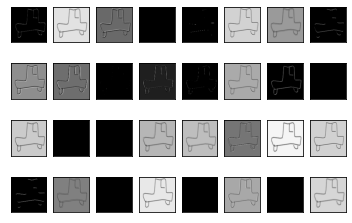

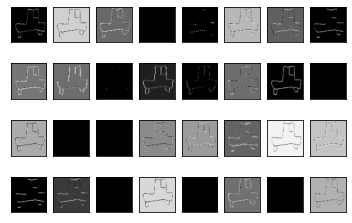

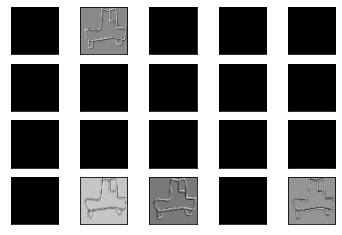

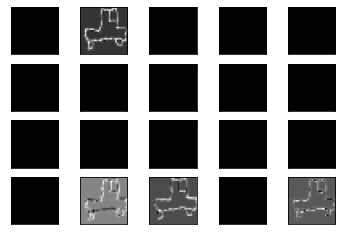

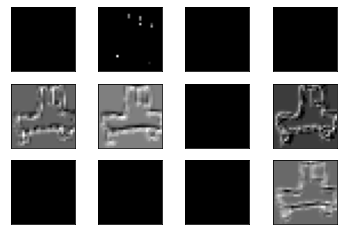

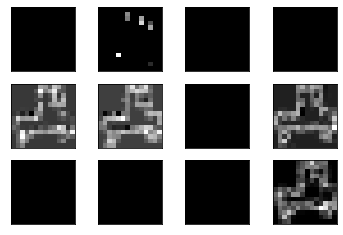

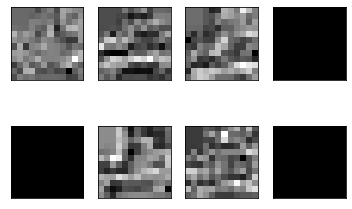

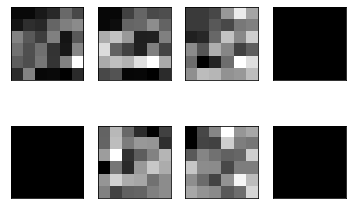

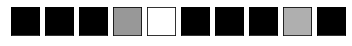

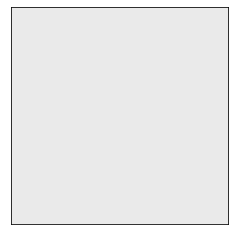

In [23]:
plot_activation(activations[0], 4, 8)
plot_activation(activations[1], 4, 8)
plot_activation(activations[2], 4, 5)
plot_activation(activations[3], 4, 5)
plot_activation(activations[4], 3, 4)
plot_activation(activations[5], 3, 4)
plot_activation(activations[6], 2, 4)
plot_activation(activations[7], 2, 4)
plot_neuron(activations[8], 20)  # 288)
plot_neuron(activations[9], 10)  # 128)
plot_neuron(activations[10], 1, vmin=0, vmax=1)